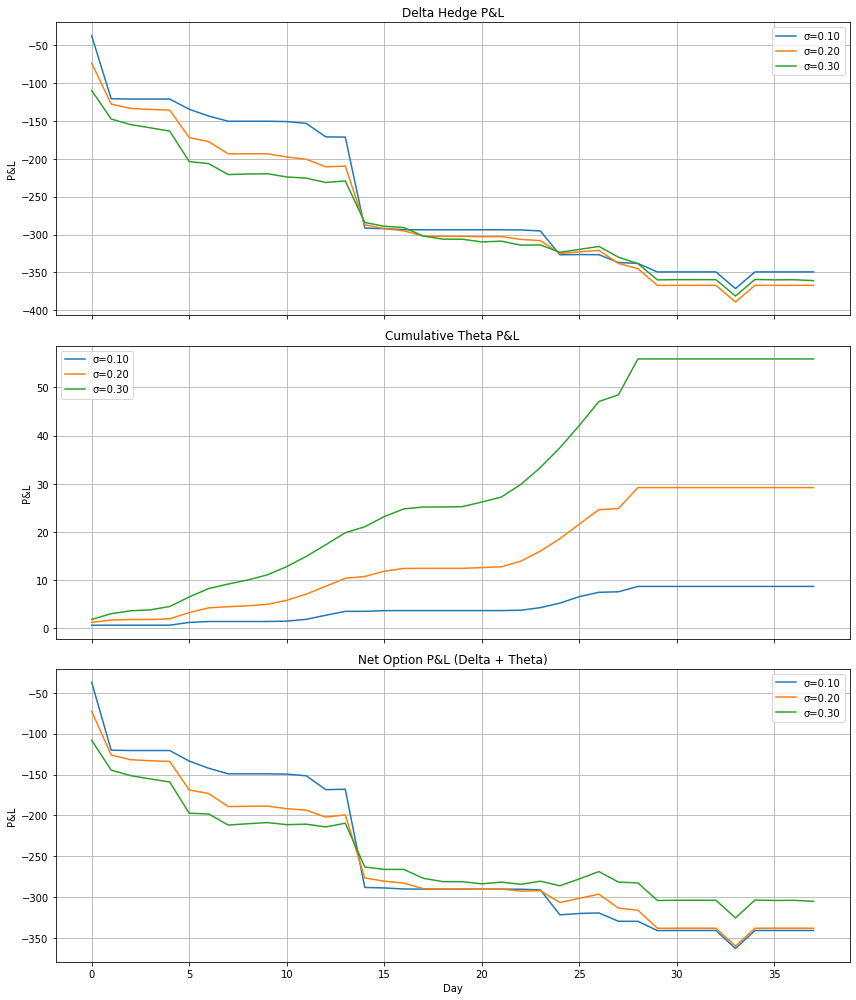

In [56]:
import datetime
import numpy as np
import backtrader as bt
import matplotlib.pyplot as plt
from scipy.stats import norm

# Black-Scholes Functions
def bs_call_price(S, K, T, r, sigma):
    if T <= 0:
        return max(S - K, 0)
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

def bs_delta(S, K, T, r, sigma):
    if T <= 0 or sigma <= 0 or S <= 0:
        return 0
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    return norm.cdf(d1)

# Define strategy
class HedgeComparison(bt.Strategy):
    params = dict(
        sigma=0.20,         # Implied volatility
        r=0.01,             # Risk-free rate
        expiry_days=30      # Option life in trading days
    )

    def __init__(self):
        self.days = 0
        self.price_hist = []
        self.cash = 0
        self.stock_position = 0
        self.strike_price = None
        self.dataclose = self.datas[0].close
        self.initial_option_price = None
        self.hedge_pnl_series = []
        self.theta_pnl_series = []
        self.net_pnl_series = []

    def next(self):
        S = self.dataclose[0]
        self.price_hist.append(S)

        if self.days == 0:
            self.strike_price = S
            T = self.p.expiry_days / 252
            self.initial_option_price = bs_call_price(S, self.strike_price, T, self.p.r, self.p.sigma)
            self.cash += self.initial_option_price * 100

        T = max((self.p.expiry_days - self.days) / 252, 0)
        call_val_today = bs_call_price(S, self.strike_price, T, self.p.r, self.p.sigma)

        # Delta hedge
        if T > 0:
            delta = bs_delta(S, self.strike_price, T, self.p.r, self.p.sigma)
            target_shares = delta * 100
            trade_size = target_shares - self.stock_position
            self.cash -= trade_size * S
            self.stock_position += trade_size

        # Delta Hedge P&L
        portfolio_value = self.cash + self.stock_position * S - call_val_today * 100
        delta_pnl = portfolio_value - self.initial_option_price * 100
        self.hedge_pnl_series.append(delta_pnl)

        # Theta P&L
        if T > 1/252:
            call_val_tmr = bs_call_price(S, self.strike_price, T - 1/252, self.p.r, self.p.sigma)
            theta_pnl = (call_val_today - call_val_tmr) * 100
        else:
            theta_pnl = 0
        self.theta_pnl_series.append(theta_pnl)

        # Net P&L = delta hedge P&L + cumulative theta
        net_pnl = delta_pnl + sum(self.theta_pnl_series)
        self.net_pnl_series.append(net_pnl)

        self.days += 1

# Load data
data = bt.feeds.YahooFinanceCSVData(
    dataname='oracle.csv',
    fromdate=datetime.datetime(2000, 1, 1),
    todate=datetime.datetime(2000, 2, 28),
    reverse=False)

# Test for different implied vol
sigmas = [0.10, 0.20, 0.30]
results_dict = {}

for sigma in sigmas:
    cerebro = bt.Cerebro()
    cerebro.adddata(data)
    cerebro.addstrategy(HedgeComparison, sigma=sigma)
    res = cerebro.run()
    strat = res[0]
    results_dict[f"σ={sigma:.2f}"] = {
        'hedge': strat.hedge_pnl_series,
        'theta': np.cumsum(strat.theta_pnl_series),
        'net': strat.net_pnl_series
    }

# Plot results
fig, axes = plt.subplots(3, 1, figsize=(12, 14), sharex=True)

for label, series in results_dict.items():
    axes[0].plot(series['hedge'], label=label)
    axes[1].plot(series['theta'], label=label)
    axes[2].plot(series['net'], label=label)

axes[0].set_title("Delta Hedge P&L")
axes[1].set_title("Cumulative Theta P&L")
axes[2].set_title("Net Option P&L (Delta + Theta)")

for ax in axes:
    ax.legend()
    ax.grid(True)
    ax.set_ylabel("P&L")

axes[2].set_xlabel("Day")
plt.tight_layout()
plt.show()


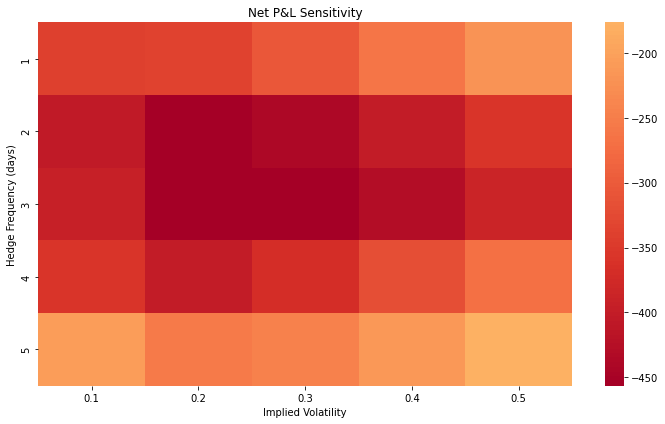

In [60]:
import datetime
import numpy as np
import backtrader as bt
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

# Black-Scholes
def bs_call_price(S, K, T, r, sigma):
    if T <= 0: return max(S - K, 0)
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

def bs_delta(S, K, T, r, sigma):
    if T <= 0 or sigma <= 0 or S <= 0: return 0
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    return norm.cdf(d1)

# Strategy
class NetPLStrategy(bt.Strategy):
    params = dict(
        sigma=0.20,
        r=0.01,
        expiry_days=30,
        hedge_interval=1
    )

    def __init__(self):
        self.days = 0
        self.cash = 0
        self.stock_position = 0
        self.price_hist = []
        self.strike_price = None
        self.dataclose = self.datas[0].close
        self.initial_option_price = None
        self.theta_pnl_series = []
        self.delta_pnl_series = []
        self.net_pnl_series = []

    def next(self):
        S = self.dataclose[0]
        self.price_hist.append(S)

        if self.days == 0:
            self.strike_price = S
            T = self.p.expiry_days / 252
            self.initial_option_price = bs_call_price(S, self.strike_price, T, self.p.r, self.p.sigma)
            self.cash += self.initial_option_price * 100

        T = max((self.p.expiry_days - self.days) / 252, 0)
        call_val_today = bs_call_price(S, self.strike_price, T, self.p.r, self.p.sigma)

        # Delta hedge every N days
        if T > 0 and self.days % self.p.hedge_interval == 0:
            delta = bs_delta(S, self.strike_price, T, self.p.r, self.p.sigma)
            target_shares = delta * 100
            trade_size = target_shares - self.stock_position
            self.cash -= trade_size * S
            self.stock_position += trade_size

        # Delta P&L
        portfolio_value = self.cash + self.stock_position * S - call_val_today * 100
        delta_pnl = portfolio_value - self.initial_option_price * 100
        self.delta_pnl_series.append(delta_pnl)

        # Theta P&L
        if T > 1 / 252:
            call_val_tmr = bs_call_price(S, self.strike_price, T - 1 / 252, self.p.r, self.p.sigma)
            theta_pnl = (call_val_today - call_val_tmr) * 100
        else:
            theta_pnl = 0
        self.theta_pnl_series.append(theta_pnl)

        net_pnl = delta_pnl + sum(self.theta_pnl_series)
        self.net_pnl_series.append(net_pnl)

        self.days += 1

# Load data
data = bt.feeds.YahooFinanceCSVData(
    dataname='oracle.csv',
    fromdate=datetime.datetime(2000, 1, 1),
    todate=datetime.datetime(2000, 2, 28),
    reverse=False)

# Sensitivity Analysis
sigma_list = [0.1, 0.2, 0.3, 0.4, 0.5]
hedge_freqs = [1, 2, 3, 4, 5]
heatmap = np.zeros((len(hedge_freqs), len(sigma_list)))

# Run Simulations
for i, hf in enumerate(hedge_freqs):
    for j, sigma in enumerate(sigma_list):
        cerebro = bt.Cerebro()
        cerebro.adddata(data)
        cerebro.addstrategy(NetPLStrategy, sigma=sigma, hedge_interval=hf)
        result = cerebro.run()
        strat = result[0]
        heatmap[i, j] = strat.net_pnl_series[-1]

# Plot Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap, annot=True, fmt=".1f",
            xticklabels=sigma_list,
            yticklabels=hedge_freqs,
            cmap="RdYlGn", center=0)
plt.title("Net P&L Sensitivity")
plt.xlabel("Implied Volatility")
plt.ylabel("Hedge Frequency (days)")
plt.tight_layout()
plt.show()
